`# Facial Expression Recognition

In [ ]:
!pip install poutyne
!pip install torchsummary

In [1]:
import os
import tarfile
import urllib.request
import json
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder, VisionDataset
from torchvision.utils import make_grid
from torchmetrics import MeanAbsoluteError

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, BatchMetric, EarlyStopping, ReduceLROnPlateau
from zipfile import ZipFile
from torchsummary import summary
from PIL import Image

In [2]:
set_seeds(42)

We download the dataset.

In [3]:
set_seeds(42)
base_path = './datasets/fer_2013'
zip_file_name = 'fer_2013.zip'
base_image_path = os.path.join(base_path, 'images')
zip_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_2013.zip'
train_json_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_faces_train.json'
test_json_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_faces_test.json'
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
gender_classes = ['female', 'male']

mma_base_path = './datasets/mma_facial_recognition'
mma_zip_file_name = 'mma_facial_expression.zip'
mma_base_image_path = os.path.join(mma_base_path, 'images')
mma_download_url = 'https://storage.googleapis.com/unsw_comp9444/facial_expressions/mma_facial_expression.zip'

In [4]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")
loss_weights={'age': 1/2100, 'gender': 1/2, 'emotion': 1/7}
batch_size = 32
test_batch_size = 128
learning_rate = 0.0001
weight_decay = 0.01
n_epoch = 70
max_age = 116
n_gender_classes = 2
n_emotion_classes = 7
image_size = 48 #original size of the image

In [5]:
def download_and_extract_dataset(base_path, extract_path, file_name, zip_url, train_json_url, test_json_url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)
    train_json_filename = os.path.join(base_path, 'fer_faces_train.json')
    test_json_filename = os.path.join(base_path, 'fer_faces_test.json')

    print('Downloading dataset...')
    urllib.request.urlretrieve(zip_url, zip_filename)
    urllib.request.urlretrieve(train_json_url, train_json_filename)
    urllib.request.urlretrieve(test_json_url, test_json_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
download_and_extract_dataset(base_path, base_image_path, zip_file_name, zip_url, train_json_url, test_json_url) 

def mma_download_and_extract_dataset(base_path, extract_path, file_name, url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)

    print('Downloading dataset...')
    urllib.request.urlretrieve(url, zip_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
mma_download_and_extract_dataset(mma_base_path, mma_base_image_path, mma_zip_file_name, mma_download_url)    

Extracting archive...
Extracting archive...


In [26]:
class FacesImageFolder(VisionDataset):        
    def __init__(self, root, labels_json_file, transform = None, target_transform = None, is_valid_file = None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.labels_json_file = labels_json_file
        
        with open(self.labels_json_file, 'r') as f:
            self.labels_json = json.load(f)
            
        self.emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.emotion_to_idx = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
        self.gender_classes = ['female', 'male']
        self.gender_to_idx = {'female': 0, 'male': 1}
        
    def __getitem__(self, index):
        label_json = self.labels_json[index]
    
        age = label_json['age']
        age_idx = int(age / 5)
        gender = label_json['gender']['value'].lower()
        emotion = label_json['emotion'].lower()
        image_path = label_json['imagePath']

        path = os.path.join(self.root, image_path)
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, (torch.FloatTensor([age]), self.gender_to_idx[gender], self.emotion_to_idx[emotion])
    def __len__(self):
        return len(self.labels_json)
    
    def loader(self, path):
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

In [27]:
augment_transform = transforms.Compose(
    [                
        transforms.ToTensor(),
        transforms.RandomAffine(degrees = 5, translate = (0.1, 0.1), shear = 5),        
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomPerspective(),   
        #transforms.RandomAdjustSharpness(sharpness_factor=2),
        #transforms.RandomAutocontrast(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5,), (0.25,))
    ]
)

test_valid_transform = transforms.Compose(
    [        
        transforms.ToTensor(),
        #transforms.Grayscale(1),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

train_image_path = os.path.join(base_image_path, 'train')
train_labels_jons_path = os.path.join(base_path, 'fer_faces_train.json')
valid_image_path = os.path.join(mma_base_image_path, 'MMAFEDB/valid')
test_image_path = os.path.join(mma_base_image_path, 'MMAFEDB/test')

train_dataset = FacesImageFolder(
    base_image_path,
    train_labels_jons_path,
    transform=augment_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

train_transform = transforms.Compose(
    [                
        transforms.ToTensor(),
        transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
        #transforms.RandomAutocontrast(),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomPerspective(),    
        #transforms.Grayscale(1),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

valid_dataset = ImageFolder(
    valid_image_path,
    transform=test_valid_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

test_dataset = ImageFolder(
    test_image_path,
    transform=test_valid_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

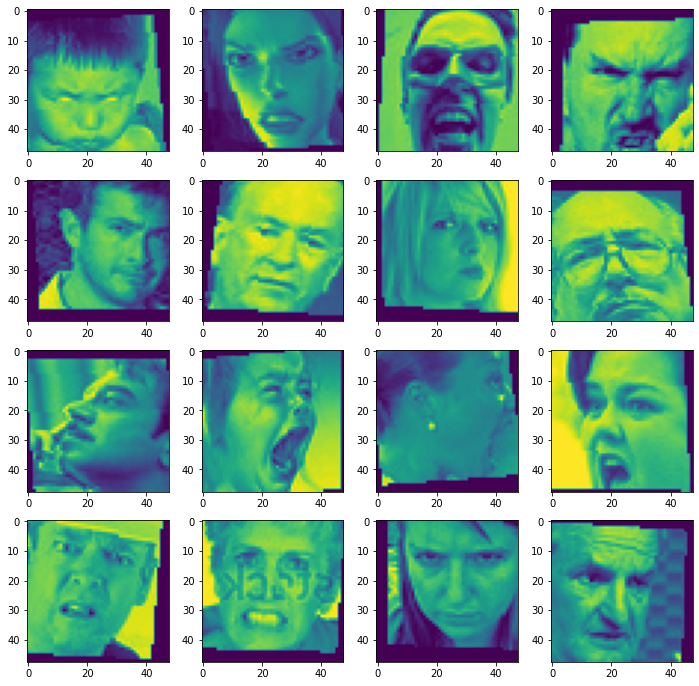

In [11]:
def show_batch(dataset):
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, (image, label) in enumerate(dataset):
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0))
        if i >= 15:
            break
            
show_batch(train_dataset)          

In [13]:
print(len(train_dataset))
print(len(valid_dataset))

28423
17356


Creation of the PyTorch's dataloader to split our data into batches.

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=0)

In [15]:
class AgeGenderEmotionNetork(nn.Module):
    
    def __init__(self):
        super(AgeGenderEmotionNetork, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')    
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn_conv1 = nn.BatchNorm2d(64)
        self.dropout_conv1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout2d(0.25)        
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.dropout_conv4 = nn.Dropout2d(0.25)        
        
        self.conv5_age = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_age = nn.BatchNorm2d(512)    
        self.dropout_conv5_age = nn.Dropout2d(0.25)
        
        self.conv5_gender = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_gender = nn.BatchNorm2d(512)    
        self.dropout_conv5_gender = nn.Dropout2d(0.25)   
        
        self.conv5_emotion = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_emotion = nn.BatchNorm2d(512)    
        self.dropout_conv5_emotion = nn.Dropout2d(0.25)           
        
        self.fc1 = nn.Linear(4608, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout_fc2 = nn.Dropout(0.25)
        
        flatten_length = 4608
        self.fc1_age = nn.Linear(flatten_length, 512)
        self.bn_fc1_age = nn.BatchNorm1d(512)
        self.dropout_fc1_age = nn.Dropout(0.25)
        
        self.fc1_gender = nn.Linear(flatten_length, 512)
        self.bn_fc1_gender = nn.BatchNorm1d(512)
        self.dropout_fc1_gender = nn.Dropout(0.25)
        
        self.fc1_emotion = nn.Linear(flatten_length, 512)
        self.bn_fc1_emotion = nn.BatchNorm1d(512)
        self.dropout_fc1_emotion = nn.Dropout(0.25)
        
        self.fc2_age = nn.Linear(512, 256)
        self.bn_fc2_age = nn.BatchNorm1d(256)
        self.dropout_fc2_age = nn.Dropout(0.25)    
        
        self.fc2_gender = nn.Linear(512, 256)
        self.bn_fc2_gender = nn.BatchNorm1d(256)
        self.dropout_fc2_gender = nn.Dropout(0.25)
        
        self.fc2_emotion = nn.Linear(512, 256)
        self.bn_fc2_emotion = nn.BatchNorm1d(256)
        self.dropout_fc2_emotion = nn.Dropout(0.25)
        
        self.fc3_out_age = nn.Linear(256, 1)
        self.fc3_out_gender = nn.Linear(256, n_gender_classes)
        self.fc3_out_emotion = nn.Linear(256, n_emotion_classes)        
        
    def forward(self, input):    
        output = F.relu(self.conv1(input))      
        output = F.relu(self.conv2(output))
        output = self.bn_conv1(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv1(output)
        
        output = F.relu(self.conv3(output))
        output = self.bn_conv3(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv3(output)
        
        output = F.relu(self.conv4(output))
        output = self.bn_conv4(output)        
        output = self.maxpool(output)    
        output = self.dropout_conv4(output)
        
        output_age = F.relu(self.conv5_age(output))
        output_age = self.bn_conv5_age(output_age)
        output_age = self.maxpool(output_age)            
        output_age = self.dropout_conv5_age(output_age) 
        
        output_gender = F.relu(self.conv5_gender(output))
        output_gender = self.bn_conv5_gender(output_gender)
        output_gender = self.maxpool(output_gender)            
        output_gender = self.dropout_conv5_gender(output_gender)  
        
        output_emotion = F.relu(self.conv5_emotion(output))
        output_emotion = self.bn_conv5_emotion(output_emotion)
        output_emotion = self.maxpool(output_emotion)            
        output_emotion = self.dropout_conv5_emotion(output_emotion)          
        
        # Flattening process
        output_age = torch.flatten(output_age, start_dim=1)
        output_gender = torch.flatten(output_gender, start_dim=1)
        output_emotion = torch.flatten(output_emotion, start_dim=1)
                
        output_age = F.relu(self.fc1_age(output_age))
        output_age = self.bn_fc1_age(output_age)
        output_age = self.dropout_fc1_age(output_age)
        
        output_gender = F.relu(self.fc1_gender(output_gender))
        output_gender = self.bn_fc1_gender(output_gender)
        output_gender = self.dropout_fc1_gender(output_gender)   
        
        output_emotion = F.relu(self.fc1_emotion(output_emotion))
        output_emotion = self.bn_fc1_emotion(output_emotion)
        output_emotion = self.dropout_fc1_emotion(output_emotion)   
        
        output_age = F.relu(self.fc2_age(output_age))
        output_age = self.bn_fc2_age(output_age)
        output_age = self.dropout_fc2_age(output_age)        
        output_age = self.fc3_out_age(output_age)
        
        output_gender = F.relu(self.fc2_gender(output_gender))
        output_gender = self.bn_fc2_gender(output_gender)
        output_gender = self.dropout_fc2_gender(output_gender)        
        output_gender = self.fc3_out_gender(output_gender)
        
        output_emotion = F.relu(self.fc2_emotion(output_emotion))
        output_emotion = self.bn_fc2_emotion(output_emotion)
        output_emotion = self.dropout_fc2_emotion(output_emotion)        
        output_emotion = self.fc3_out_emotion(output_emotion)
        
        return output_emotion
    
age_gender_emotion_netork = AgeGenderEmotionNetork().to(device)
print(summary(age_gender_emotion_netork, input_size=(1, image_size, image_size)))        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
            Conv2d-2           [-1, 64, 48, 48]          18,496
       BatchNorm2d-3           [-1, 64, 48, 48]             128
         MaxPool2d-4           [-1, 64, 24, 24]               0
         Dropout2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
       BatchNorm2d-7          [-1, 128, 24, 24]             256
         MaxPool2d-8          [-1, 128, 12, 12]               0
         Dropout2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
        Dropout2d-13            [-1, 256, 6, 6]               0
           Conv2d-14            [-1, 51

In [17]:
class AgeGenderEmotionLoss(nn.Module):
    def __init__(self, weights=None):
        super(AgeGenderEmotionLoss, self).__init__()           
        self.weights = weights
 
    def forward(self, inputs, targets, smooth=1):        
        cross_entropy_loss = nn.CrossEntropyLoss()
        mse_loss = nn.MSELoss()        
                
        [age_inputs, gender_inputs, emotion_inputs] = inputs
        [age_targets, gender_targets, emotion_targets] = targets    

        
        age_loss = mse_loss(age_inputs, age_targets)
        gender_loss = cross_entropy_loss(gender_inputs, gender_targets)
        emotion_loss = cross_entropy_loss(emotion_inputs, emotion_targets) 

        weighted_loss = age_loss * self.weights['age'] +  gender_loss * self.weights['gender'] + emotion_loss * self.weights['emotion']        
        return weighted_loss

We define callbacks for saving last epoch, best epoch and logging the results.

In [18]:
# We are saving everything into ./saves/cub200.
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'cnn')
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [25]:
optimizer = optim.Adam(age_gender_emotion_netork.parameters(), lr=learning_rate)
loss_function = AgeGenderEmotionLoss(loss_weights)

model = Model(
    age_gender_emotion_netork,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks    
)

test_loss, (test_acc, test_f1), y_predict, y_true = model.evaluate_generator(test_loader, return_pred=True, return_ground_truth=True)

ValueError: too many values to unpack (expected 3)

In [14]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

   epoch        time  lr_group_0  lr_group_1      loss        acc  \
0      1  570.479348       0.001       0.001  1.405087  48.898546   
1      2  220.268181       0.001       0.001  1.229331  56.582910   

   fscore_macro  val_loss    val_acc  val_fscore_macro  
0      0.283608  1.425864  48.000691          0.273209  
1      0.343551  1.340421  50.725974          0.298112  
Best epoch: 2


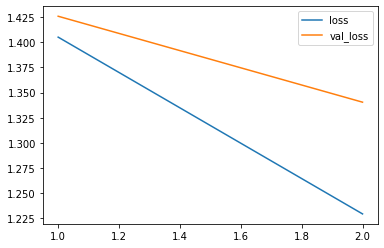

In [15]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

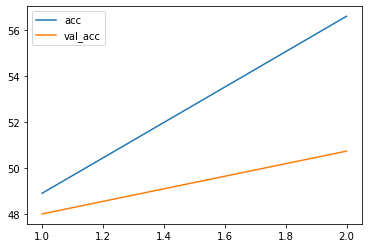

In [16]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

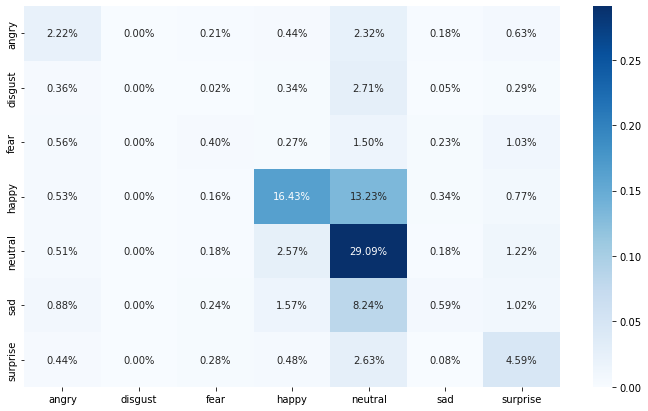

In [17]:
os.makedirs('./plots', exist_ok=True)
cf_matrix = confusion_matrix(y_true, np.argmax(y_predict, axis=1))
class_names = list(train_dataset.class_to_idx)

plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.savefig('./plots/confusion_matrix.png')